<a href="https://colab.research.google.com/github/andres4ramos/167/blob/main/10_5_Convolution_For_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 10.5: Convolution for MNIST**

This notebook builds a proper network for 2D convolution.  It works with the MNIST dataset (figure 15.15a), which was the original classic dataset for classifying images.  The network will take a 28x28 grayscale image and classify it into one of 10 classes representing a digit.

The code is adapted from https://nextjournal.com/gkoehler/pytorch-mnist

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

In [3]:


# Set batch sizes for training and test data
batch_size_train = 64
batch_size_test = 1000

# Directory to save/download the MNIST data
myDir = '/files/'  # Change this path to a valid directory on your machine if necessary

# Define transformations: Convert to tensor and normalize data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std of MNIST dataset
])

# Load training data
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        myDir, train=True, download=True, transform=transform
    ),
    batch_size=batch_size_train,
    shuffle=True
)

# Load test data
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        myDir, train=False, download=True, transform=transform
    ),
    batch_size=batch_size_test,
    shuffle=True
)

# Check data loading
for (images, labels) in train_loader:
    print(f"Batch size: {images.size()}, Labels: {labels.size()}")
    break


Batch size: torch.Size([64, 1, 28, 28]), Labels: torch.Size([64])


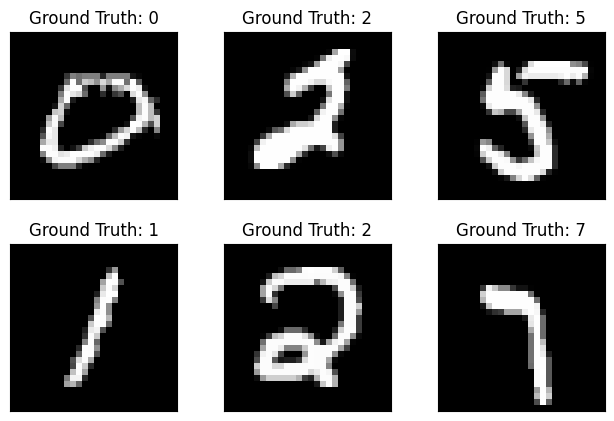

In [4]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

Define the network.  This is a more typical way to define a network than the sequential structure.  We define a class for the network, and define the parameters in the constructor.  Then we use a function called forward to actually run the network.  It's easy to see how you might use residual connections in this format.

In [6]:


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 1. First convolution layer: 1 input channel, 10 output channels, kernel size 5
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)

        # 2. Max pooling layer over a 2x2 area (for down-sampling)
        self.pool = nn.MaxPool2d(2, 2)

        # 4. Second convolution layer: 10 input channels, 20 output channels, kernel size 5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)

        # 5. 2D Dropout layer to reduce overfitting
        self.drop = nn.Dropout2d()

        # 9. Fully connected layer mapping from (320 dimensions here) to 50
        self.fc1 = nn.Linear(320, 50)

        # 11. Fully connected layer mapping from 50 to 10 (output classes)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # 1. Convolution -> 3. ReLU -> 2. Max Pooling
        x = self.pool(F.relu(self.conv1(x)))

        # 4. Second Convolution -> 7. ReLU -> 6. Max Pooling
        x = self.pool(F.relu(self.conv2(x)))

        # 5. Dropout for regularization
        x = self.drop(x)

        # 8. Flattening the tensor for the fully connected layers
        x = x.view(-1, 320)  # Flattening the tensor to match input of fc1

        # 9. Fully connected layer -> 10. ReLU
        x = F.relu(self.fc1(x))

        # 11. Second fully connected layer
        x = self.fc2(x)

        # 12. Softmax activation for output layer
        x = F.log_softmax(x, dim=1)

        return x


In [7]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [8]:
# Create network
model = Net()
# Initialize model weights
model.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [9]:
# Main training routine
def train(epoch):
  model.train()
  # Get each
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    # Store results
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

In [10]:
# Run on test data
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# Get initial performance
test()
# Train for three epochs
n_epochs = 3
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3960, Accuracy: 992/10000 (10%)

Train Epoch: 1 [0/60000]	Loss: 2.462214
Train Epoch: 1 [640/60000]	Loss: 2.236007
Train Epoch: 1 [1280/60000]	Loss: 2.137291
Train Epoch: 1 [1920/60000]	Loss: 2.028086
Train Epoch: 1 [2560/60000]	Loss: 2.012391
Train Epoch: 1 [3200/60000]	Loss: 1.759601
Train Epoch: 1 [3840/60000]	Loss: 1.682634
Train Epoch: 1 [4480/60000]	Loss: 1.357158
Train Epoch: 1 [5120/60000]	Loss: 1.253560
Train Epoch: 1 [5760/60000]	Loss: 1.308620
Train Epoch: 1 [6400/60000]	Loss: 0.910074
Train Epoch: 1 [7040/60000]	Loss: 0.832123
Train Epoch: 1 [7680/60000]	Loss: 0.723807
Train Epoch: 1 [8320/60000]	Loss: 0.777384
Train Epoch: 1 [8960/60000]	Loss: 0.698991
Train Epoch: 1 [9600/60000]	Loss: 0.933884
Train Epoch: 1 [10240/60000]	Loss: 0.659414
Train Epoch: 1 [10880/60000]	Loss: 0.933144
Train Epoch: 1 [11520/60000]	Loss: 0.853056
Train Epoch: 1 [12160/60000]	Loss: 0.468219
Train Epoch: 1 [12800/60000]	Loss: 0.676275
Train Epoch: 1 [13440/60000]	Loss: 0.62

In [ ]:
# Run network on data we got before and show predictions
output = model(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()